# Forecasting 

![extrapolating](https://imgs.xkcd.com/comics/extrapolating.png)

In this lesson, we will practice forecasting using the following methods:  

- Last Observed Value  
- Simple Average  
- Moving Average
- Previous Cycle 
- Holt's Linear Trend
- Holt's Seasonal Trend
 

![time series overview of methods in this lesson](forecasting_overview.png)

In this lesson we will:
- Acquire and prepare store sales data stored in our Codeup MySQL server.
- Forecast future values using each modeling approach.
- Evaluate competing model performance.

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# wrangle
from env import user, password, host
import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

## Wrangle

We will acquire the data from our MySQL server and cache a local .csv version of our data if it is not already present.
 

In [2]:
def get_db_url(database):
    '''
    Returns a formatted string using credentials stored in env.py that can be passed to a pd.read_sql() function
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [3]:
def get_store_data():
    '''
    Returns a dataframe of all store data in the tsa_item_demand database and saves a local copy as a csv file.
    '''
    if os.path.exists('tsa_store_data.csv'):
        df = pd.read_csv('tsa_store_data.csv')
    else:
        query = '''
                SELECT *
                FROM items
                JOIN sales USING(item_id)
                JOIN stores USING(store_id)
                '''

        df = pd.read_sql(query, get_db_url('tsa_item_demand'))
        df.to_csv('tsa_store_data.csv', index=False)
    return df

In [4]:
def wrangle_store_data():
    '''
    Checks for a local cache of tsa_store_data.csv and if not present will run the get_store_data() function which acquires data from Codeup's mysql server
    '''
    filename = 'tsa_store_data.csv'
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
    else:
        df = get_store_data()
    return df

In [5]:
df = wrangle_store_data()

In [6]:
df.head(2)

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,sale_date,sale_amount,store_address,store_zipcode,store_city,store_state
0,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1,2013-01-01,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
1,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2,2013-01-02,11,12125 Alamo Ranch Pkwy,78253,San Antonio,TX


## Prepare

1. Convert the `sale_date` column to be a datetime type.
2. Set index and sort values by date
3. Rename `sale_amount` to `quantity` to make the two columns easier to understand what the data represents. 
4. Create a new field called `sales_total` that is the product of `quantity` and `item_price`.
5. Confirm our approach using `.head()`, `.info()`, and `.describe()`.
6. Resample to a daily period.
7. Drop the leap year days

### Preliminary Data Cleaning

In [7]:
[col for col in df.columns]

['store_id',
 'item_id',
 'item_upc14',
 'item_upc12',
 'item_brand',
 'item_name',
 'item_price',
 'sale_id',
 'sale_date',
 'sale_amount',
 'store_address',
 'store_zipcode',
 'store_city',
 'store_state']

In [8]:
def prep_store_data(df):
    '''
    Prepares raw store data for analysis and time series modeling.
    '''
    # convert the sale date to a datetime
    df.sale_date = pd.to_datetime(df['sale_date'])
    # make that value our index value
    df = df.set_index('sale_date').sort_index()
    #rename any messy columns that could get confusing:
    df = df.rename(columns={'sale_amount': 'quantity'})
    #engineer sales total by multiplying quantity by item price
    df['sales_total'] = df.quantity * df.item_price
    return df


In [9]:
df = prep_store_data(df)

Let's take a look at our data:

In [10]:
df.head(3)

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,quantity,store_address,store_zipcode,store_city,store_state,sales_total
sale_date,,,,,,,,,,,,,,
2013-01-01,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,10.92
2013-01-01,3,17,88313590791,88313590791,Ducal,Ducal Refried Red Beans,1.16,295813,26,2118 Fredericksburg Rdj,78201,San Antonio,TX,30.16
2013-01-01,10,7,70177154004,70177154004,Twinings Of London,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,125995,32,8503 NW Military Hwy,78231,San Antonio,TX,308.48


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   store_id       913000 non-null  int64  
 1   item_id        913000 non-null  int64  
 2   item_upc14     913000 non-null  int64  
 3   item_upc12     913000 non-null  int64  
 4   item_brand     913000 non-null  object 
 5   item_name      913000 non-null  object 
 6   item_price     913000 non-null  float64
 7   sale_id        913000 non-null  int64  
 8   quantity       913000 non-null  int64  
 9   store_address  913000 non-null  object 
 10  store_zipcode  913000 non-null  int64  
 11  store_city     913000 non-null  object 
 12  store_state    913000 non-null  object 
 13  sales_total    913000 non-null  float64
dtypes: float64(2), int64(7), object(5)
memory usage: 104.5+ MB


In [12]:
df.describe()

,store_id,item_id,item_upc14,item_upc12,item_price,sale_id,quantity,store_zipcode,sales_total
count,913000.000000,913000.000000,9.130000e+05,9.130000e+05,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,2.384688e+11,2.384688e+11,5.160400,456500.500000,52.250287,78224.800000,280.898866
std,2.872283,14.430878,2.978005e+11,2.978005e+11,2.737764,263560.542223,28.801144,16.479087,227.686575
min,1.000000,1.000000,8.500005e+09,8.500005e+09,0.600000,1.000000,0.000000,78201.000000,0.000000
25%,3.000000,13.000000,3.367410e+10,3.367410e+10,2.970000,228250.750000,30.000000,78217.000000,98.010000
50%,5.500000,25.500000,7.103651e+10,7.103651e+10,5.195000,456500.500000,47.000000,78220.500000,233.280000
75%,8.000000,38.000000,6.030842e+11,6.030842e+11,7.520000,684750.250000,70.000000,78232.000000,402.780000
max,10.000000,50.000000,8.846237e+11,8.846237e+11,9.640000,913000.000000,231.000000,78253.000000,2104.410000


We will resample to daily aggregating our values using sum. The original granularity is daily, but there are multiple records of the same days across multiple stores. 

In [13]:
# resample by day, sum
df_resampled = df.resample('d')[['quantity', 'sales_total']].sum()

In [14]:
df_resampled.head(2)

,quantity,sales_total
sale_date,,
2013-01-01,13696,73844.01
2013-01-02,13678,73570.58


In [15]:
df_resampled.shape

(1826, 2)

In [16]:
df_resampled.loc['2016-02-29']

quantity       16916.00
sales_total    90944.03
Name: 2016-02-29 00:00:00, dtype: float64

In [17]:
# Drop February 29th from our dataset (a leap year date)
# we do have a leap day in this data set, so I'm going
# to drop it out so it doesn't disrupt our annual cycle/365 count
df_resampled = df_resampled[df_resampled.index != '2016-02-29']

In [18]:
df_resampled.head(2)

,quantity,sales_total
sale_date,,
2013-01-01,13696,73844.01
2013-01-02,13678,73570.58


## Split

1. We will use the training proportion method to split.    
2. Identify the total length of the dataframe and multiple by `train_prop` to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data.   (`x = train_prop * 100`)  
3. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.  
4. Return train and test dataframes.  

In [19]:
.5 * df_resampled.shape[0]

912.5

In [20]:
int(.5 * len(df_resampled))

912

In [21]:
# take 50% of our data for train (round to integer for a whole number)
train_size = int(.5 * len(df_resampled))
# take 30% for validation
validate_size = int(len(df_resampled) * .3)
# get the remainder or rows for test
test_size = int(len(df_resampled) - train_size - validate_size)
# get the delineation point between validate and test by summing train and validate
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]

In [22]:
train.shape[0] + validate.shape[0] + test.shape[0]

1825

## Visualizing Our Data

Let's plot our data first, viewing where the data is split into train and test. 

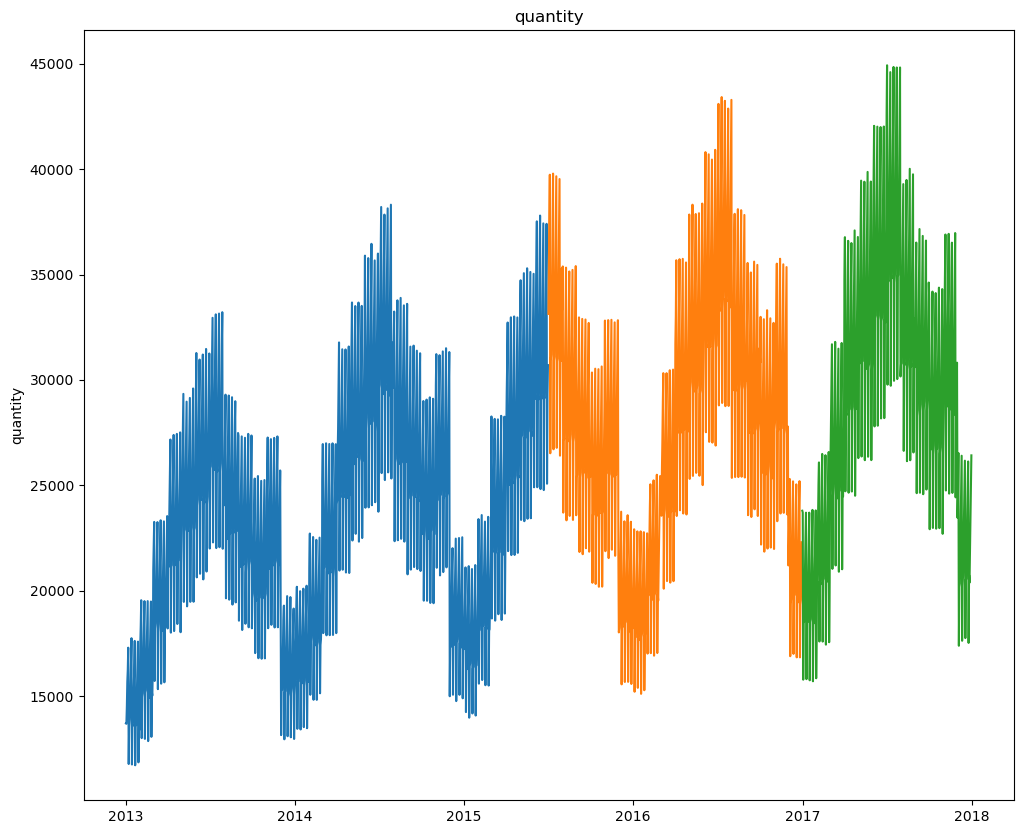

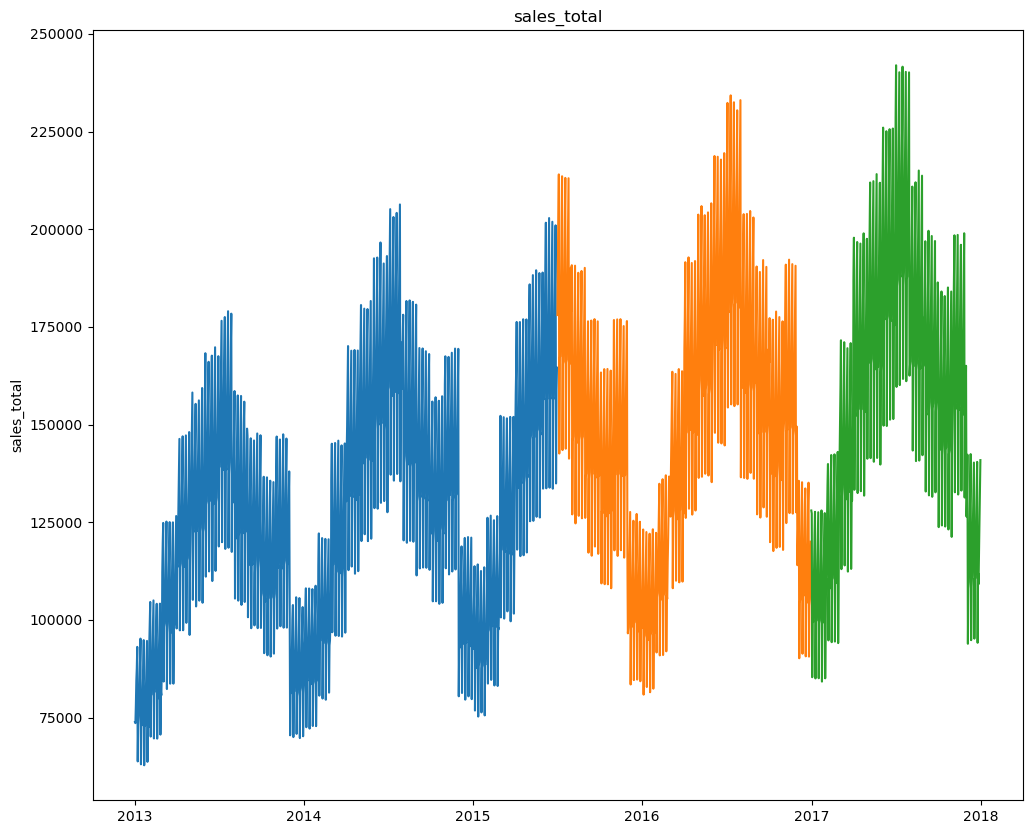

In [23]:
# plotting the values of quantity and sales over time by data subset:
for col in train.columns:
    plt.figure(figsize=(12,10))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

## Creating Helpful Evaluation Functions

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow. 

`evaluate()` will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.  

In [24]:
# evaluation function to compute rmse
# calculate an error metric on the validation's target versus predictions
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(
        sqrt(
            mean_squared_error(
            validate[target_var],
            yhat_df[target_var])
        ), 0)
    return rmse

    

`plot_and_eval()` will use the evaluate function and also plot train and test values with the predicted values in order to visualize our performance to make comparisons.

In [25]:
# plot and evaluate 
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var], linewidth=1)
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, f'-- rmse: {round(rmse,2)}')
    plt.show()

We are planning on evaluating a lot of models. Let's create an easy to read dataframe called `eval_df`. We will eventually add the metrics we calculate for each of our models to this dataframe for easy comparison.

In [26]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


While we could manually append the performance results of each model to this dataframe, its better to create a function that will do it for us.

`append_eval_df()` will append evaluation metrics for each model into our eval_df data frame object. This function is dependent on `eval_df` already existing, which we accomplished in our previous step.

In [27]:
# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    return pd.concat([eval_df, pd.DataFrame(d)])

## Forecast

Forecasting is another word for predicting time series data. As a reminder, we will work with the following approaches:

#### Baseline Models
1. Last Observed Value
2. Simple Average
3. Moving Average

#### Non-Baseline Models
4. Previous Cycle
5. Holt's Linear Trend
6. Holt's Seasonal Trend

### Last Observed Value

The simplest method for forecasting is to predict all future values to be the last observed value.  


**Make Predictions**

In [28]:
# going forward from the -1st element in train's sales total, then 
# rip out the value associated with it by taking the zeroth element of that return
train['sales_total'][-1:][0]

164573.2

In [29]:
# take the last item of sales total and assign to variable
# indexing: last thing to the end, then the first element
last_sales = train['sales_total'][-1:][0]

# take the last item of quantity and assign to variable
last_quantity = train['quantity'][-1:][0]

# let's make the prediction dataframe that we referenced a little earlier
yhat_df = pd.DataFrame(
    {
    'sales_total': [last_sales],
    'quantity': [last_quantity]
    },
    index = validate.index
)


In [30]:
yhat_df.head()

,sales_total,quantity
sale_date,,
2015-07-02,164573.2,30703
2015-07-03,164573.2,30703
2015-07-04,164573.2,30703
2015-07-05,164573.2,30703
2015-07-06,164573.2,30703


You can see, when peeking into yhat_df, that every predicted value is the same.  

**Plot Actual vs. Predicted Values**

Now, let's plot actual and predicted values using our plot_and_eval() function:

quantity -- rmse: 6621.0


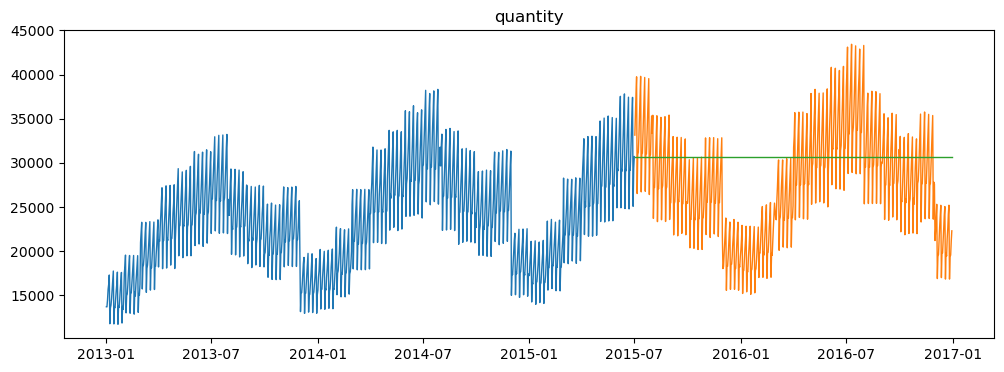

sales_total -- rmse: 35402.0


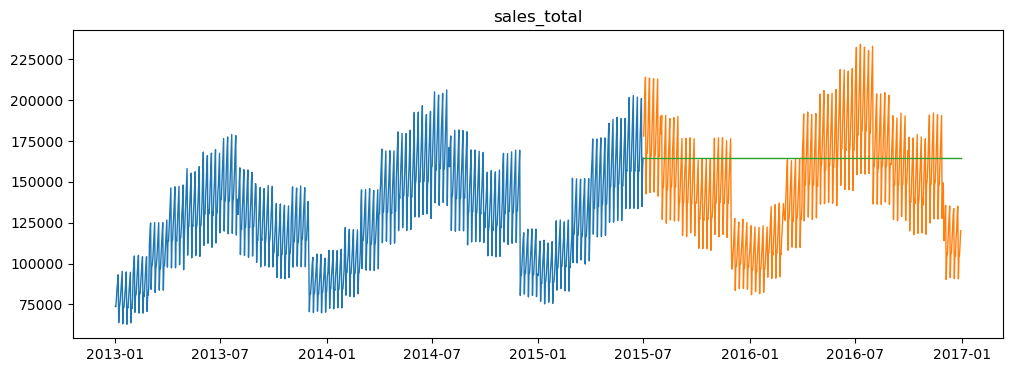

In [31]:
# use the plot and eval function we defined earlier for both targets:
for col in train.columns:
    plot_and_eval(col)

**Evaluate** 

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`. We will add our metrics via our `append_eval_df()` function.

In [32]:
eval_df

,model_type,target_var,rmse


In [33]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value',
                             target_var=col)

In [34]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,6621.0
0,last_observed_value,sales_total,35402.0


### Simple Average

Take the simple average of historical values and use that value to predict future values.   

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train. 


**Make Predictions**

In [35]:
# compute simple average of sales_total (from train data)
avg_sales = round(train['sales_total'].mean(), 2)

# compute simple average of quantity (from train data)
avg_quantity = round(train['quantity'].mean(), 2)


yhat_df = pd.DataFrame({'sales_total': [avg_sales],
                        'quantity': [avg_quantity]},
                        index=validate.index)

yhat_df.head(3)

,sales_total,quantity
sale_date,,
2015-07-02,127517.85,23717.94
2015-07-03,127517.85,23717.94
2015-07-04,127517.85,23717.94


### Plot Actual vs. Predicted Values

Similar to our handling of the previous baseline model, we can plot our `yhat_df` values against the actual values in validate. Our `plot_and_eval` function accomplishes this.

quantity -- rmse: 7378.0


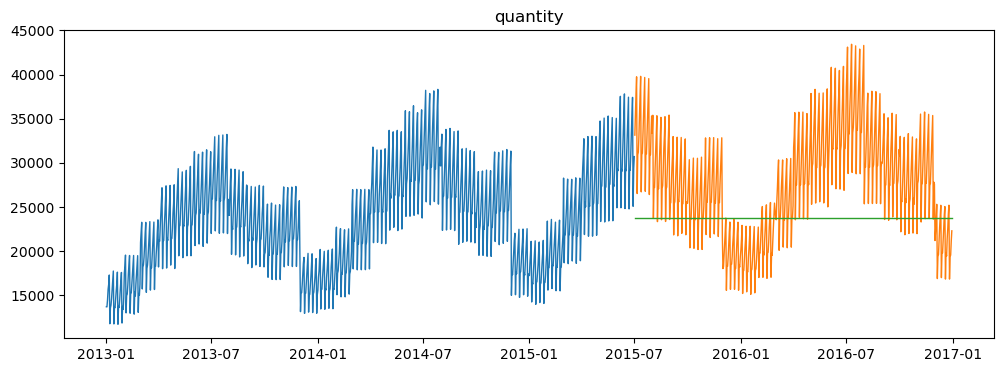

sales_total -- rmse: 39664.0


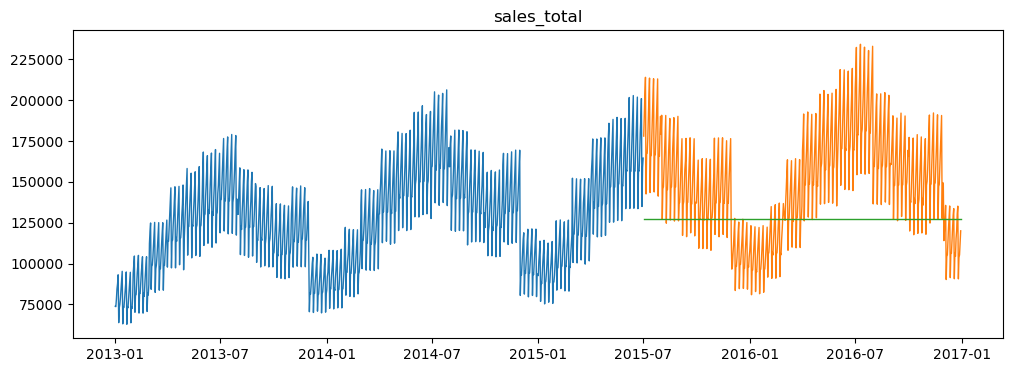

In [36]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [37]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,6621.0
0,last_observed_value,sales_total,35402.0
0,simple_average,quantity,7378.0
0,simple_average,sales_total,39664.0


### Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average of the last period, here 30-days, will be used as the forecasted value. 

> Moving averages are moving and change over time, but only historically. Forecasts using the moving average use the average of the last period/window of time.

![moving average forecast diagram](moving_average.png)

**Make Predictions**

There are several ways to obtain the mean of the last 30 periods in train. We will use the `.rolling()` method to accomplish this.

In [38]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 30

rolling_sales = round(
    train['sales_total'].rolling(period).mean()[-1], 2)
rolling_quantity = round(
    train['quantity'].rolling(period).mean()[-1], 2)

# yhat_df = make_predictions()

yhat_df = pd.DataFrame({'sales_total': rolling_sales,
                        'quantity': rolling_quantity},
                         index=validate.index)
yhat_df.head()

,sales_total,quantity
sale_date,,
2015-07-02,168957.91,31432.77
2015-07-03,168957.91,31432.77
2015-07-04,168957.91,31432.77
2015-07-05,168957.91,31432.77
2015-07-06,168957.91,31432.77


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Moving Average**

quantity -- rmse: 6954.0


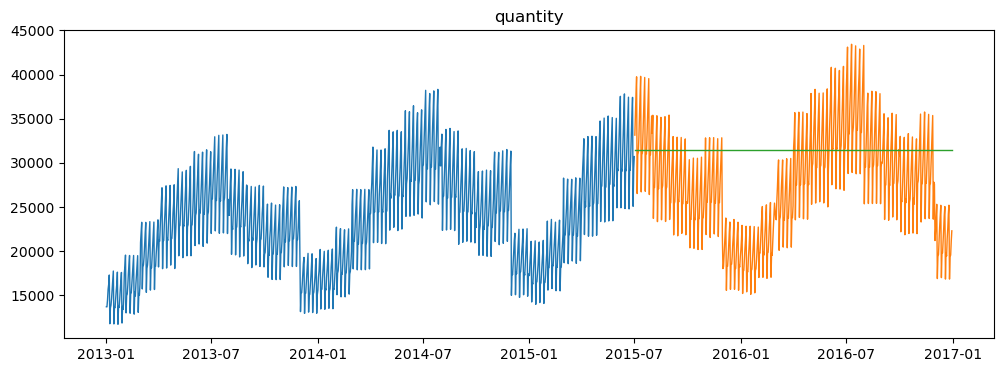

sales_total -- rmse: 37378.0


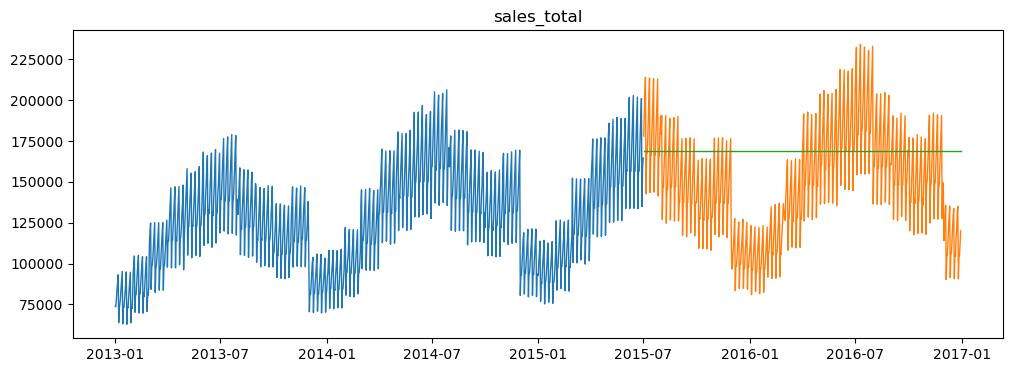

In [39]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [40]:
for col in train.columns:
    eval_df = append_eval_df(model_type='30d moving average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,6621.0
0,last_observed_value,sales_total,35402.0
0,simple_average,quantity,7378.0
0,simple_average,sales_total,39664.0
0,30d moving average,quantity,6954.0
0,30d moving average,sales_total,37378.0


Let's try out several other values for periods:

In [41]:
periods = [4, 12, 26, 52, 104]

for p in periods: 
    rolling_sales = round(
    train['sales_total'].rolling(p).mean()[-1], 2)
    rolling_quantity = round(
    train['quantity'].rolling(p).mean()[-1], 2)
    yhat_df = pd.DataFrame(
        {
            'sales_total' : [rolling_sales],
            'quantity': [rolling_quantity]
        },
        index=validate.index
    )
    model_type = str(p) + '_day_moving_avg'
    # lets update the eval_df (remember we have two targets!)
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                 target_var = col)

In [42]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,6621.0
0,last_observed_value,sales_total,35402.0
0,simple_average,quantity,7378.0
0,simple_average,sales_total,39664.0
0,30d moving average,quantity,6954.0
0,30d moving average,sales_total,37378.0
0,4_day_moving_avg,quantity,6592.0
0,4_day_moving_avg,sales_total,35515.0
0,12_day_moving_avg,quantity,6992.0
0,12_day_moving_avg,sales_total,37644.0


Which is best so far? 

In [43]:
eval_df.groupby('target_var')['rmse'].min()

target_var
quantity        6101.0
sales_total    32803.0
Name: rmse, dtype: float64

In [44]:
# get the min rmse for each variable

min_rmse_sales_total = eval_df.groupby(
    'target_var')['rmse'].min()[1]
min_rmse_quantity = eval_df.groupby(
    'target_var')['rmse'].min()[0]

In [45]:
min_rmse_sales_total

32803.0

In [46]:
eval_df[(eval_df.rmse == min_rmse_sales_total) | 
       (eval_df.rmse == min_rmse_quantity)]

,model_type,target_var,rmse
0,104_day_moving_avg,quantity,6101.0
0,104_day_moving_avg,sales_total,32803.0


As far as baselines are concerned, it looks like our 104 day moving average is a good starting point for comparisons.
# Non-Baseline Models

## Holt-Winters
Two of the models that we will evaluate are based on Holt-Winters, which models on three elements:
- A typical value (average)
- A slope (trend) over time
- And a cyclical repeating pattern (seasonality)

Its worth looking at a seasonal decomposition plot of our target, to inspect these components:

#### Seasonal Decomposition

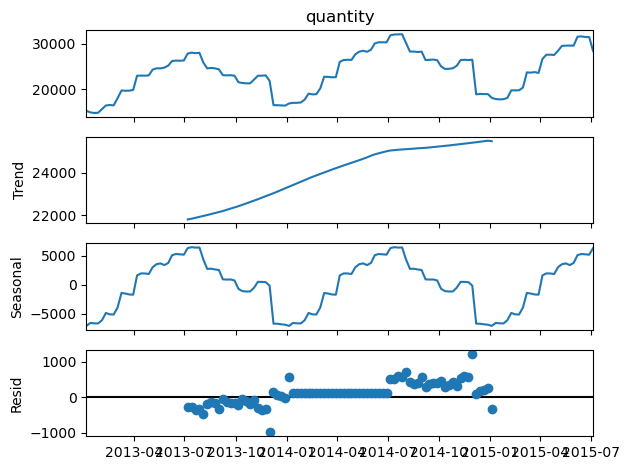

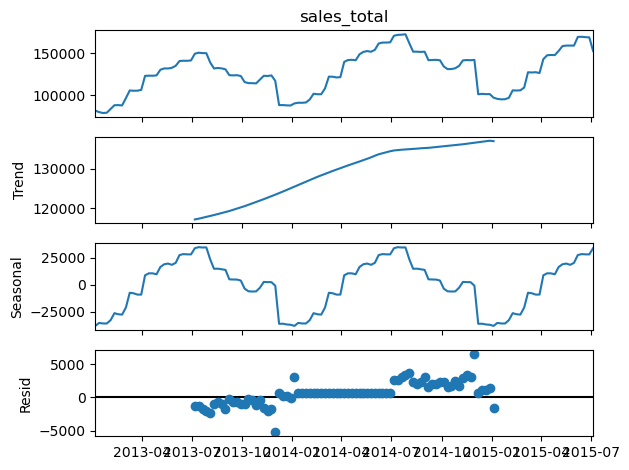

In [47]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()

It looks like there is both strong seasonality and a notable trend in both targets (`sales_total` and `quantity`). There are two Holt-Winters models that we will attempt
- Holt's Linear Trend
- Holt's Seasonal Model

### Holt's Linear Trend

Our approach will be similar to many other modeling processes we have performed:
1. Create the object: `Holt()`
2. Fit the object: `.fit()`
3. Make predictions: `.predict()`

The first set of hyperparameters are set when we call `Holt()`: 

- **exponential** = True/False (exponential vs. linear growth, additive vs. multiplicative)
- **damped $\phi$** = True/False
    - with Holt, forecasts tend to increase or decrease indefinitely into the future.  To avoid absurd long term predictions, use the Damped method (True) which sets a damping parameter between 0< ϕ <1. 

A second set of hyperparameters are set when we call `.fit()`: 

- **smoothing_level ($\alpha$)**: value between (0,1)
    - Closer to 0, the level doesn't change with each new observation
    - Closer to 1, the level reacts strongly with each new observation
- **smoothing_slope ($\beta$)**: value between (0,1)
    - Closer to 0, trend is not changing over time
    - Closer to 1, trend is changing significantly over time
- **optimized**: use the auto-optimization that allow statsmodels to automatically find an optimized value for us. 

#### Basic Holt's Linear Trend

![diagram of holts linear trent](holts.png)

**Make Predictions**

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions. 

In [48]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start=validate.index[0],
                                end= validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)

/Users/madeleinecapper/miniconda3/envs/homebase/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/madeleinecapper/miniconda3/envs/homebase/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/madeleinecapper/miniconda3/envs/homebase/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/madeleinecapper/miniconda3/envs/homebase/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [49]:
yhat_df.head()

,sales_total,quantity
sale_date,,
2015-07-02,170207.53,31656.49
2015-07-03,170328.01,31678.93
2015-07-04,170447.29,31701.15
2015-07-05,170565.37,31723.15
2015-07-06,170682.27,31744.93


**Plot Actual vs. Predicted Values**

quantity -- rmse: 8225.0


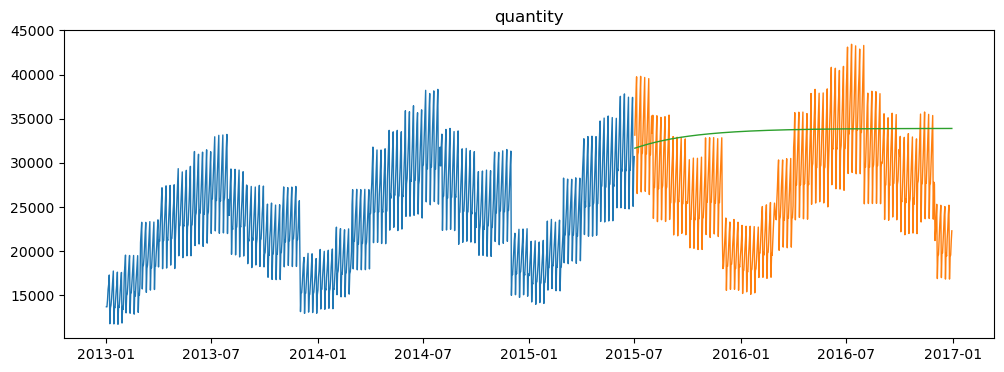

sales_total -- rmse: 44226.0


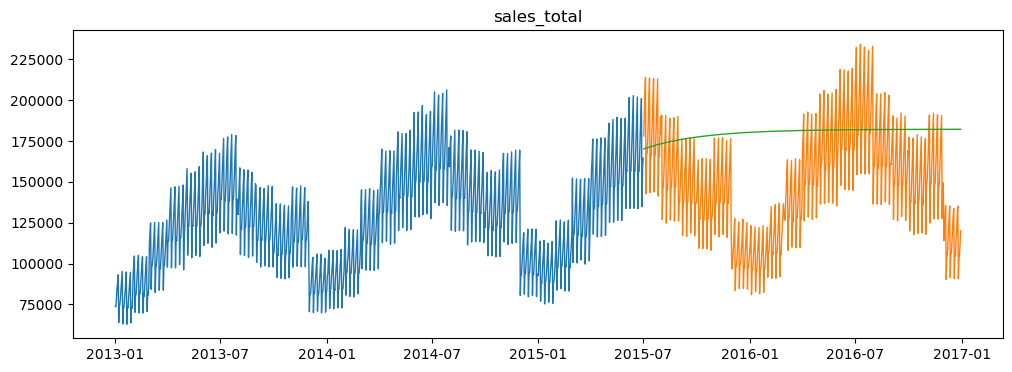

In [50]:
for col in train.columns:
    plot_and_eval(target_var = col)

**Evaluate**

In [51]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

### Holt's Seasonal Trend

Holt's Seasonal Trend is started by using `ExponentialSmoothing()`

The process is similar to our previous model:
1. Create the object: `ExponentialSmoothing()`
2. Fit the object: `.fit()`
3. Make predictions: `.forecast()`

This function has several hyperparameters:
- **seasonal_periods**: The number of periods representing one cycle of seasonality. This is why performing a decomposition plot can be valuable, as this number needs to be entered manually.
- **trend**: Whether the overall trend is additive (`trend='add'`) or multiplicative (`trend='mul'`)
- **seasonal**: Whether the seasonality is additive (`seasonal='add'`) or multiplicative (`seasonal='mul'`)
- **damped**: If we want the trend to reduce over the length of the forecast to avoid absurd long term predictions, we can set `damped=True`

Given our smaller dataset, rather than choosing any one combination of hyperparameters, we can create multiple models to test different combinations:

___
<center>Quantity</center>

|model_name|seasonal_periods|trend|seasonal|damped|
|---|---|---|---|---|
|hst_quantity_fit1|365|add|add|False|
|hst_quantity_fit2|365|add|mul|False|
|hst_quantity_fit3|365|add|add|True|
|hst_quantity_fit4|365|add|mul|True|

___
<center>Sales Total</center>

|model_name|seasonal_periods|trend|seasonal|damped|
|---|---|---|---|---|
|hst_sales_fit1|365|add|add|False|
|hst_sales_fit2|365|add|mul|False|
|hst_sales_fit3|365|add|add|True|
|hst_sales_fit4|365|add|mul|True|

In [52]:
import itertools

In [53]:
combos = list(itertools.product(['add','mul'],[True, False]))

In [54]:
combos

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [55]:
# let's play with some hyperparameter combinations:
hsts = {}
for col in train.columns:
    hsts[col] = {}
    for i, combo in enumerate(combos):
        hsts[col]['hst_fit_' + str(i)] = \
        ExponentialSmoothing(train[col],
                            seasonal_periods=365,
                            trend='add',
                            seasonal=combo[0],
                            damped=combo[1]).fit()

/Users/madeleinecapper/miniconda3/envs/homebase/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/madeleinecapper/miniconda3/envs/homebase/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/madeleinecapper/miniconda3/envs/homebase/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/madeleinecapper/miniconda3/envs/homebase/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/madeleinecapper/miniconda3/envs/homebase/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_mode

In [56]:
hsts.keys()

dict_keys(['quantity', 'sales_total'])

In [57]:
hsts['sales_total']

{'hst_fit_0': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x2b7cead10>,
 'hst_fit_1': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x2b7cfda50>,
 'hst_fit_2': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x2b7d14490>,
 'hst_fit_3': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x2b7d1a450>}

In [58]:
# compare our scores
best_score = 'placeholder'
for model in hsts['quantity']:
    score = sqrt(hsts['quantity'][model].sse / len(train))
    current_model = {model: score}
    if best_score == 'placeholder':
        best_score = current_model
    else:
        if list(best_score.values())[0] > list(current_model.values())[0]:
            best_score = current_model

In [59]:
best_score

{'hst_fit_1': 3159.366982354296}

In [60]:
best_score = 'placeholder'
for model in hsts['sales_total']:
    score = sqrt(hsts['sales_total'][model].sse / len(train))
    current_model = {model: score}
    if best_score == 'placeholder':
        best_score = current_model
    else:
        if list(best_score.values())[0] \
        > list(current_model.values())[0]:
            best_score = current_model

In [61]:
best_score

{'hst_fit_1': 16968.36428927965}

The model contains a SSE attribute that we can use to compare performance. We can derive RMSE from SSE, but for now, we can just use SSE to look at the relative performance of our Holt's Seasonal Trend models.

In [62]:
best_score= 'placeholder'
for model in hsts['sales_total']:
    score = (hsts['sales_total'][model].sse / len(train)) ** .5
    current_model = {model: score}
    if best_score == 'placeholder':
        best_score = current_model
    else:
        if list(best_score.values())[0] > list(current_model.values())[0]:
            best_score = current_model

### Make Predictions

The `.forecast()` method for Holt's Seasonal models requires the number of periods the model is going to provide a prediction for **after** the end of the training data. 

In [63]:
train.shape, validate.shape, test.shape

((912, 2), (547, 2), (366, 2))

In [64]:
validate.head(1)

,quantity,sales_total
sale_date,,
2015-07-02,33134,178036.64


In [65]:
hsts['quantity']['hst_fit_1'].forecast(validate.shape[0] + 1)

2015-07-02    30633.609157
2015-07-03    30824.375920
2015-07-04    32601.133135
2015-07-05    34413.198903
2015-07-06    36222.829247
                  ...     
2016-12-26    23487.970861
2016-12-27    24825.313369
2016-12-28    24089.851561
2016-12-29    19458.764042
2016-12-30    21134.563024
Freq: D, Length: 548, dtype: float64

In [66]:
yhat_df = pd.DataFrame({'sales_total': hsts['sales_total']['hst_fit_1'].forecast(validate.shape[0] + 1),
                           'quantity': hsts['quantity']['hst_fit_1'].forecast(validate.shape[0] + 1)},
                          index=validate.index)
yhat_df

,sales_total,quantity
sale_date,,
2015-07-02,164609.196455,30633.609157
2015-07-03,165680.392742,30824.375920
2015-07-04,174895.237519,32601.133135
2015-07-05,184376.468086,34413.198903
2015-07-06,194915.370570,36222.829247
...,...,...
2016-12-26,126211.361139,23487.970861
2016-12-27,132791.315467,24825.313369
2016-12-28,129316.025782,24089.851561


quantity -- rmse: 4869.0


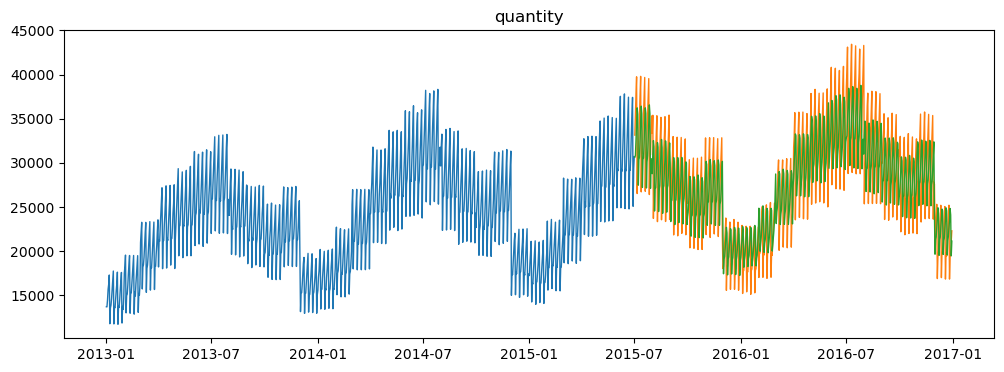

sales_total -- rmse: 26217.0


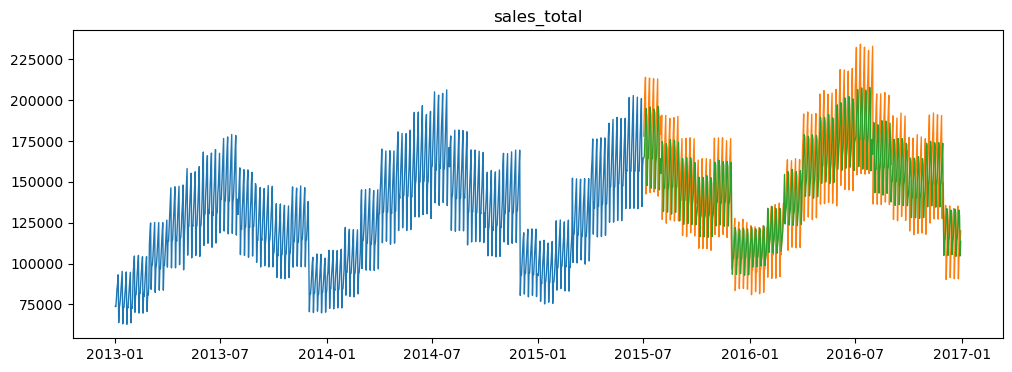

In [67]:
for col in train.columns:
    plot_and_eval(col)

In [68]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_seasonal', 
                            target_var = col)

In [69]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,holts_seasonal,quantity,4869.0
0,104_day_moving_avg,quantity,6101.0
0,52_day_moving_avg,quantity,6563.0
0,4_day_moving_avg,quantity,6592.0
0,last_observed_value,quantity,6621.0
0,30d moving average,quantity,6954.0
0,12_day_moving_avg,quantity,6992.0
0,26_day_moving_avg,quantity,7004.0
0,simple_average,quantity,7378.0
0,holts_optimized,quantity,8225.0


quantity -- rmse: 4869.0


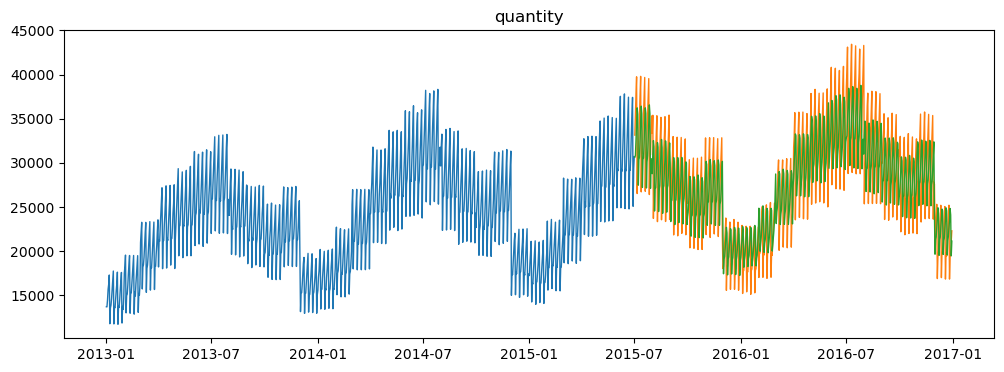

sales_total -- rmse: 26217.0


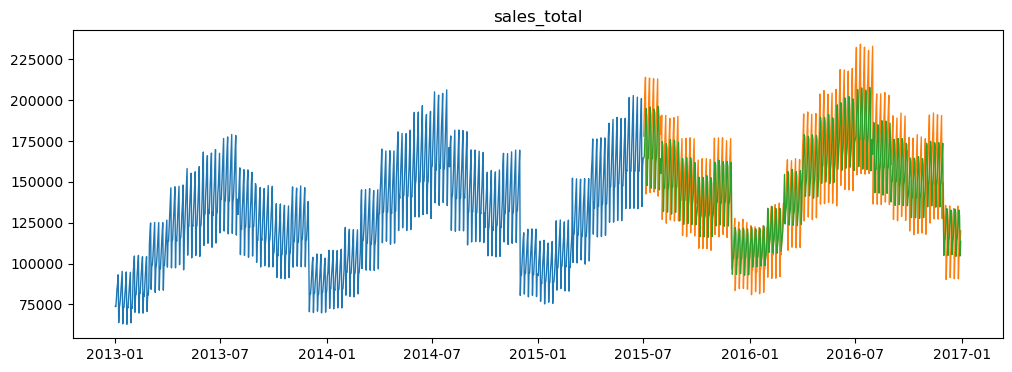

In [70]:
for col in train.columns:
    plot_and_eval(col)

In [71]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_seasonal', 
                            target_var = col)

In [72]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,holts_seasonal,quantity,4869.0
0,holts_seasonal,quantity,4869.0
0,104_day_moving_avg,quantity,6101.0
0,52_day_moving_avg,quantity,6563.0
0,4_day_moving_avg,quantity,6592.0
0,last_observed_value,quantity,6621.0
0,30d moving average,quantity,6954.0
0,12_day_moving_avg,quantity,6992.0
0,26_day_moving_avg,quantity,7004.0
0,simple_average,quantity,7378.0


Our best implementation of Holt's Seasonal Trend is significantly outperforming all other models made thus far.

### Predict Based on Previous Cycle

Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day. 

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence.

![diagram of forecasting with previous cycle](previous_cycle.png)

In the below example:  
1. Compute the 365 average year over year differences from 2013 through 2015
2. Add that average delta to the values during 2015. 
3. Set the index in your yhat dataframe to represent the dates those predictions are make for. 

Let's get started....

**Re-split data**

In [73]:
# split it up by year
train = df_resampled.loc[:'2015']
validate = df_resampled.loc['2016']
test = df_resampled.loc['2017']

**Make Predictions**

In [74]:
# find yoy diff. from 2013-2014 and 2014-2015, take the mean, and add to each value in 2015.
yhat_df = train.loc['2015'] + train.diff(365).mean()

# set yhat_df to index of validate
yhat_df.index = validate.index

In [75]:
yhat_df.head()

,quantity,sales_total
sale_date,,
2016-01-01,19411.813699,104337.620493
2016-01-02,20904.813699,112870.770493
2016-01-03,21983.813699,118245.300493
2016-01-04,23286.813699,125496.760493
2016-01-05,16420.813699,88551.940493


**Plot and Evaluate**

quantity -- rmse: 5223.0


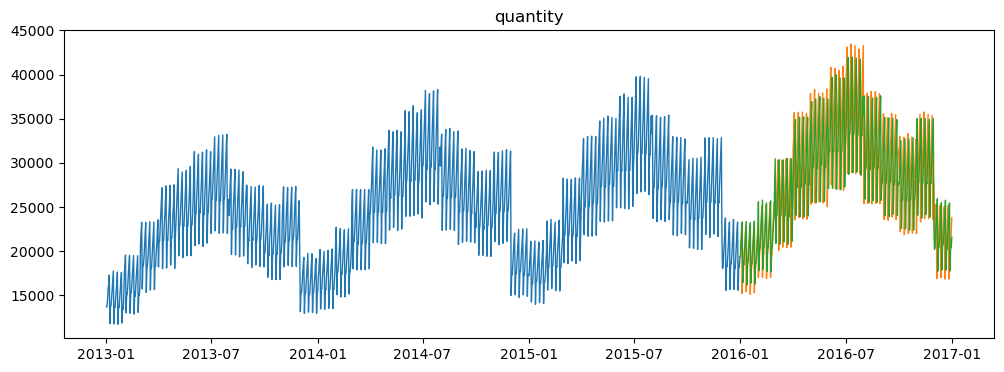

sales_total -- rmse: 28087.0


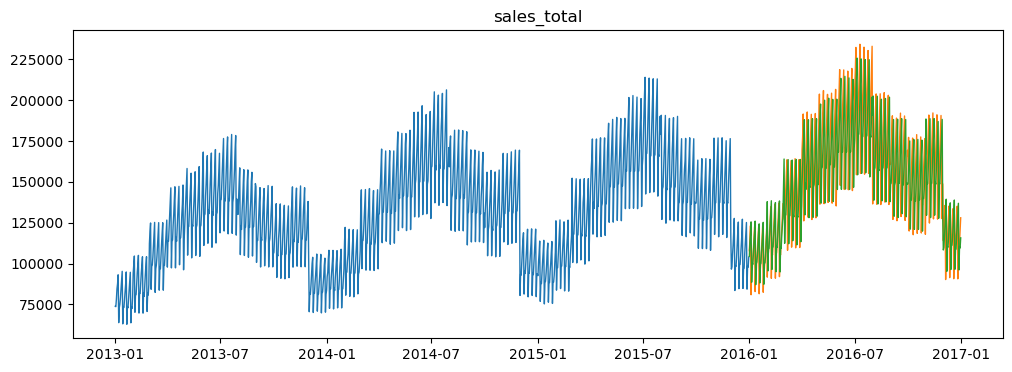

In [76]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

## Conclusion

Which model did the best? 

In [77]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,holts_seasonal,quantity,4869.0
0,holts_seasonal,quantity,4869.0
0,previous year,quantity,5223.0
0,104_day_moving_avg,quantity,6101.0
0,52_day_moving_avg,quantity,6563.0
0,4_day_moving_avg,quantity,6592.0
0,last_observed_value,quantity,6621.0
0,30d moving average,quantity,6954.0
0,12_day_moving_avg,quantity,6992.0
0,26_day_moving_avg,quantity,7004.0


In [78]:
sales_total_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

quantity_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == sales_total_min_rmse) | 
         (eval_df.rmse == quantity_min_rmse))]

,model_type,target_var,rmse
0,holts_seasonal,quantity,4869.0
0,holts_seasonal,sales_total,26217.0
0,holts_seasonal,quantity,4869.0
0,holts_seasonal,sales_total,26217.0


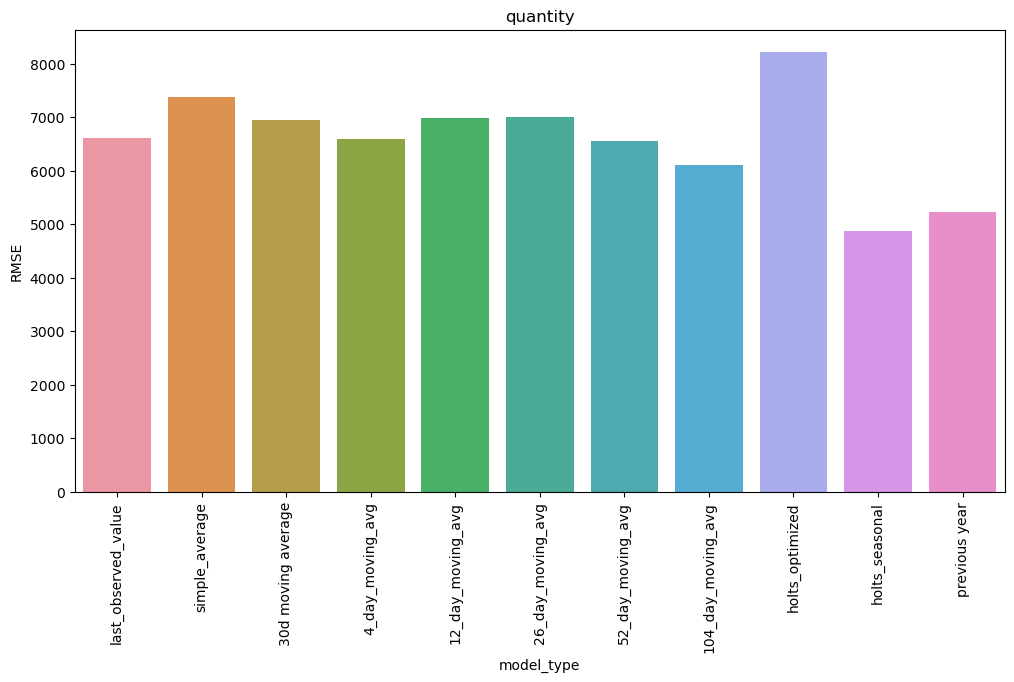

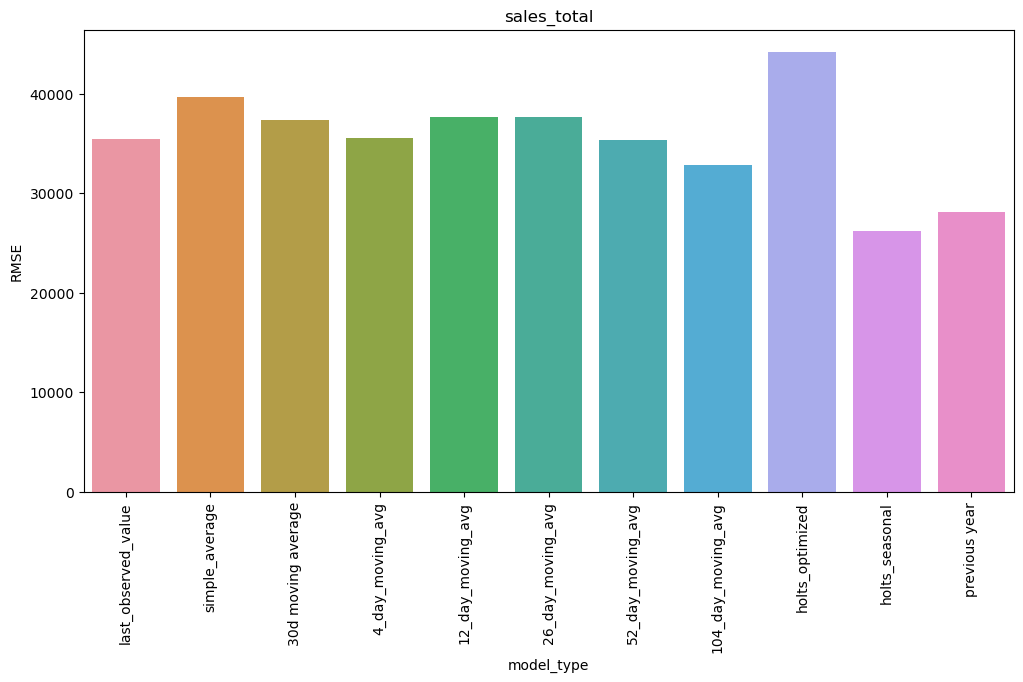

In [79]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x=x, y=y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=90)
    plt.show()

# Performance on Test

Now that we have identified our one best model for each target variable, we can evaluate its peformance on our test data. As a reminder, `.forecast()` allows us to make predictions, but the method always starts after the end of the training data. To get to the test data, we will need to increase the number of periods being predicted to be equal to the combined periods of validate and test. 

We altered our train-validate-test split to perform the previous cycle approach. Let's reset to the original train-validate-test split.

In [80]:
train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]
train.shape, validate.shape, test.shape

((912, 2), (547, 2), (366, 2))

In [81]:
yhat_df = pd.DataFrame({'sales_total': hsts['sales_total']['hst_fit_1'].forecast(validate.shape[0] + test.shape[0] + 1),
                           'quantity': hsts['quantity']['hst_fit_1'].forecast(validate.shape[0] + test.shape[0] + 1)})
yhat_df

,sales_total,quantity
2015-07-02,164609.196455,30633.609157
2015-07-03,165680.392742,30824.375920
2015-07-04,174895.237519,32601.133135
2015-07-05,184376.468086,34413.198903
2015-07-06,194915.370570,36222.829247
...,...,...
2017-12-27,144433.497246,27040.540472
2017-12-28,140958.207561,26305.078664
2017-12-29,116294.685896,21673.991145
2017-12-30,125186.623280,23349.790128


The original test set started on 2016-12-31, so we can slice out that portion from our `yhat_df`:

In [82]:
yhat_df = yhat_df['2016-12-31':]

In [83]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='train')
    plt.plot(validate[target_var], color='#ff7f00', label='validate')
    plt.plot(test[target_var], color='#4daf4a',label='test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.legend()
    plt.title(target_var)
    plt.show()

FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse-sales total:  29973.235168423114
rmse-quantity:  5600.367125634174


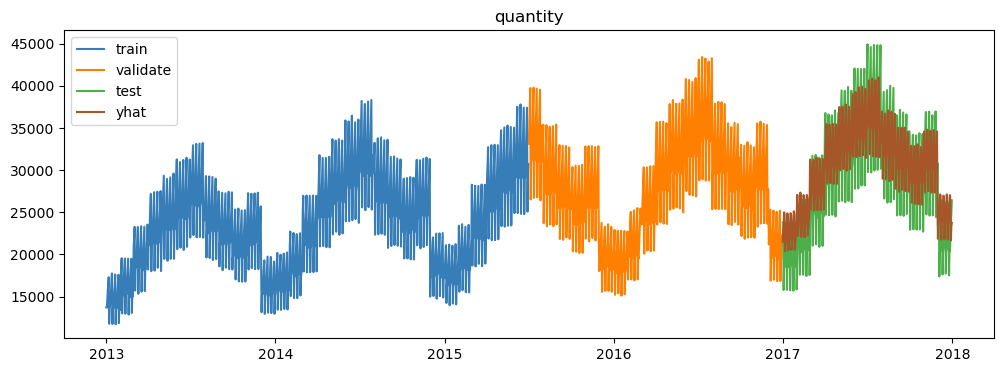

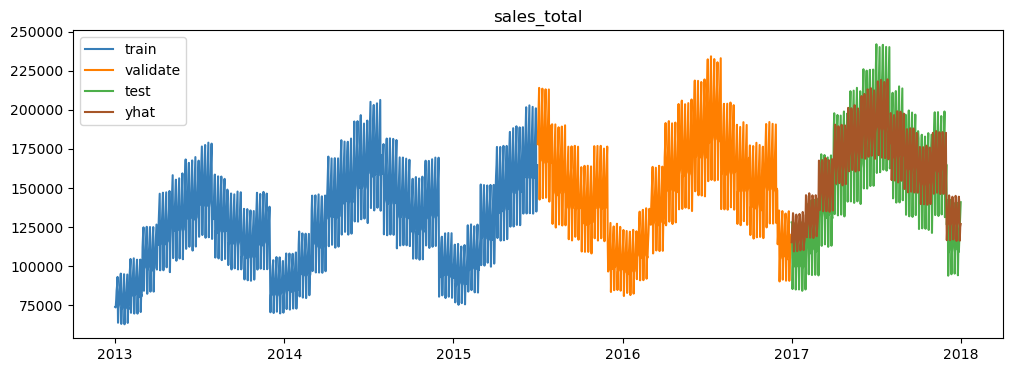

In [84]:
rmse_sales_total = sqrt(mean_squared_error(test['sales_total'], 
                                       yhat_df['sales_total']))

rmse_quantity = sqrt(mean_squared_error(test['quantity'], 
                                       yhat_df['quantity']))

print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
print('rmse-sales total: ', rmse_sales_total)
print('rmse-quantity: ', rmse_quantity)
for col in train.columns:
    final_plot(col)

Our RMSE of our final model did get noticably worse on the test data. Its possible that while the performance of the model starts high, it degrades the further out it projects. Let's take a look at what a projection into 2018 would look like.

## Forcasting Into Future

Predicting 2018 simply requires us to extend the value passed to `.forecast()` by an additional 365 periods and then slicing out what we want:

In [85]:
forecast = pd.DataFrame({'sales_total': hsts['sales_total']['hst_fit_1'].forecast(validate.shape[0] + test.shape[0] + 1 + 365),
                           'quantity': hsts['quantity']['hst_fit_1'].forecast(validate.shape[0] + test.shape[0] + 1 + 365)})
# how does forecast look

In [86]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='Train')
    plt.plot(validate[target_var], color='#ff7f00', label='Validate')
    plt.plot(test[target_var], color='#4daf4a', label='Test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.plot(forecast[target_var], color='#984ea3', label='Forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()

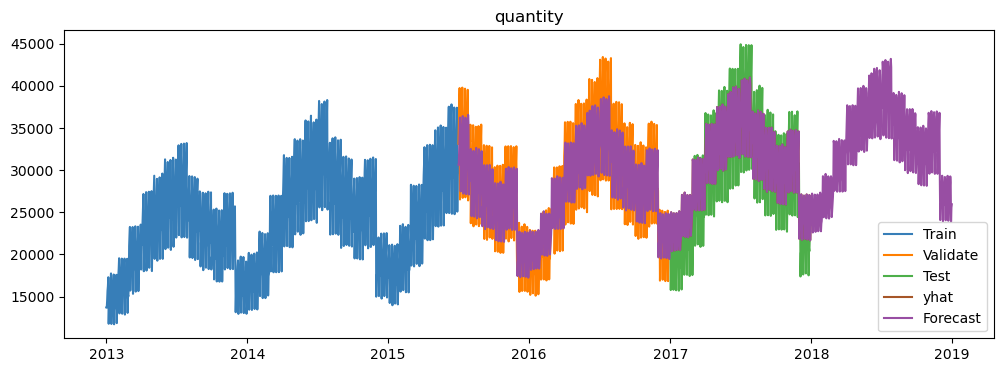

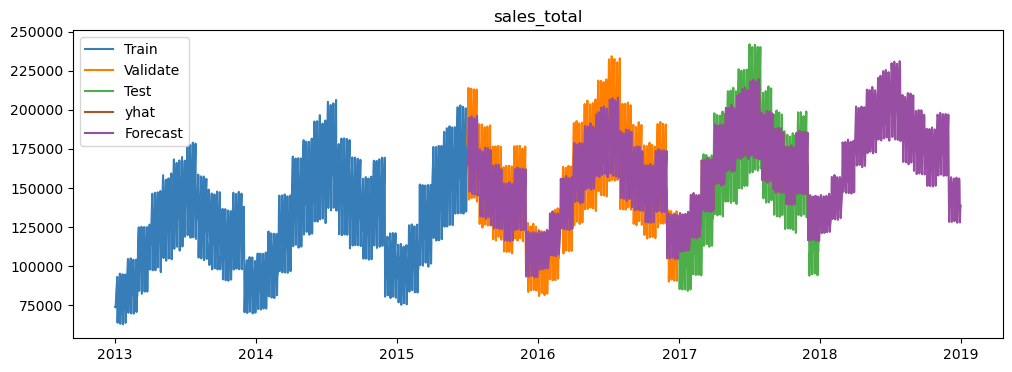

In [87]:
for col in train.columns:
    final_plot(col)

This data set was made of synthetic data with a clear and observable pattern. It allows us to observe the risk of long term performance degredation. While `Holt's Seasonal Trend` outperformed `Previous Cycle` on validate, `Previous Cycle` would have probably been the best model to use. `Holt's Seasonal Trend` is failing to demonstrate the higher maximum value in each subsequent cycle. 

>**However, I can be confident in this claim because I have atypical knowledge that this data is extremely predictable. Real data is rarely as reliable, and conclusions are rarely as clear as the example we have shown here.**

Forecasting is an art as much as it is a science, as the environment that created the values of our historical data may be very different from the environment that creates future values. 

>**"It's tough to make predictions, especially about the future." - Yogi Berra**

## Further Resources
- Modeling with [SARIMAX](https://ds.codeup.com/timeseries/sarimax/)
- Modeling with [SVR](https://ds.codeup.com/timeseries/svr/)
- The [Prophet model](https://facebook.github.io/prophet/docs/installation.html#installation-in-python) from Facebook

## Exercises

The end result of this exercise should be a Jupyter notebook named `model`.

Using [saas.csv](https://ds.codeup.com/saas.csv) or log data from API usage

1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum. 
2. Forecast, plot and evaluate using each at least 4 of the methods we discussed:
    - Last Observed Value
    - Simple Average
    - Moving Average
    - Holt's Linear Trend 
    - Holt's Seasonal Trend
    - Based on previous year/month/etc., this is up to you.

Bonus: 
1. Using the store item demand data, create a forecast of `sales_total` and `quantity` for 2018 using the `Previous Cycle` approach.  .  
2. Predict 2018 total **monthly** sales for a single store and/or item by creating a model using prophet.
3. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
4. Plot the 2018 monthly sales predictions.